el dataset fue obtenido desde aqui "https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data".
El objetivo es ver si soy capaz de hacer forecast y predecir el valor del bitcoin.

In [2]:
import pandas as pd
import numpy as np
import sklearn.preprocessing as prep
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Cargamos el csv
train = pd.read_csv('btcusd_1-min_data.csv')

print(train.shape)

# Mostramos 10 registros al azar
train.sample(10)

(6750281, 6)


,Timestamp,Open,High,Low,Close,Volume
3308348,1.523935e+09,8038.88,8042.77,8032.30,8039.73,0.626884
2326520,1.465018e+09,570.39,570.39,570.39,570.39,0.000000
3074651,1.509913e+09,7530.00,7534.72,7522.10,7522.10,7.327435
1152980,1.394598e+09,634.37,634.99,632.49,632.49,1.795600
3137444,1.513680e+09,18911.15,18911.15,18866.83,18909.72,1.409295
6608939,1.722018e+09,67548.00,67584.00,67529.00,67584.00,0.840485
468364,1.353518e+09,11.63,11.63,11.63,11.63,0.000000
6344912,1.706150e+09,39700.00,39707.00,39691.00,39698.00,0.227120
4164004,1.575281e+09,7354.18,7354.51,7354.18,7354.51,0.014531
2653267,1.484626e+09,831.67,832.23,831.67,832.23,30.184385


despues de ver la tabla me voy a centrar en el valor de cierre y es lo que voy a tratar como target
las columnas son: 
Timestamp: el tiempo
Open: el valor cuando empezo a tomar el tiempo
High: el valor mas alto que tomo durante ese tiempo
Low: el valor mas bajo que tomo durante todo ese tiempo
Close: el valor con el que finalizo el tiempo
Volume: transancciones durante ese tiempo

In [4]:
#miro donde hay nulls si los hay
train.isna().sum()

Timestamp    1
Open         0
High         0
Low          0
Close        0
Volume       0
dtype: int64

In [5]:
filas_con_nulos = train[train.isnull().any(axis=1)]
print(filas_con_nulos)

         Timestamp     Open     High      Low    Close    Volume
6750280        NaN  57854.0  57864.0  57835.0  57835.0  1.353466


In [6]:
train = train.dropna()
print(train)

            Timestamp       Open       High        Low      Close    Volume
0        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
1        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
2        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
3        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
4        1.325412e+09       4.58       4.58       4.58       4.58  0.000000
...               ...        ...        ...        ...        ...       ...
6750275  1.737936e+09  102518.00  102559.00  102506.00  102558.00  0.771165
6750276  1.737936e+09  102628.00  102669.00  102608.00  102611.00  0.086742
6750277  1.737936e+09  102659.00  102712.00  102657.00  102712.00  0.488757
6750278  1.737936e+09  102631.00  102631.00  102573.00  102573.00  0.126719
6750279  1.737936e+09  102573.00  102604.00  102507.00  102514.00  0.474495

[6750280 rows x 6 columns]


si bien podria poner el timestamp del unico valor con un null, dicidi borrarlo, un registro arriba o abajo de 6 millones creo que no va a influir

In [8]:
train['Timestamp'] = pd.to_datetime(train['Timestamp'], unit='s') 
train.set_index('Timestamp', inplace=True)
print(train)

                          Open       High        Low      Close    Volume
Timestamp                                                                
2012-01-01 10:01:00       4.58       4.58       4.58       4.58  0.000000
2012-01-01 10:02:00       4.58       4.58       4.58       4.58  0.000000
2012-01-01 10:03:00       4.58       4.58       4.58       4.58  0.000000
2012-01-01 10:04:00       4.58       4.58       4.58       4.58  0.000000
2012-01-01 10:05:00       4.58       4.58       4.58       4.58  0.000000
...                        ...        ...        ...        ...       ...
2025-01-26 23:56:00  102518.00  102559.00  102506.00  102558.00  0.771165
2025-01-26 23:57:00  102628.00  102669.00  102608.00  102611.00  0.086742
2025-01-26 23:58:00  102659.00  102712.00  102657.00  102712.00  0.488757
2025-01-26 23:59:00  102631.00  102631.00  102573.00  102573.00  0.126719
2025-01-27 00:00:00  102573.00  102604.00  102507.00  102514.00  0.474495

[6750280 rows x 5 columns]


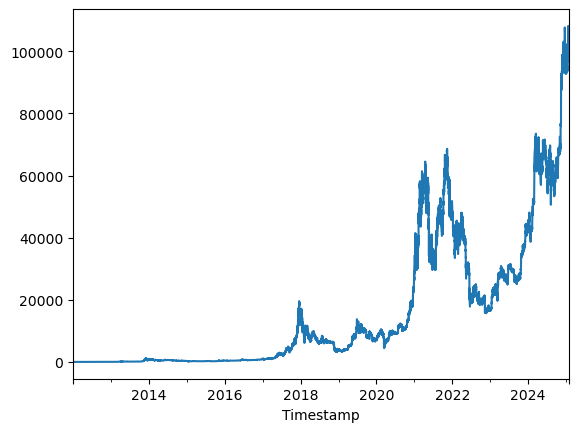

In [9]:
# Calcular la media por hora y rellenar posibles nulos
data_hour = train['Close'].resample('h').mean().ffill()

# Visualizamos la serie completa
data_hour.plot()
plt.show()

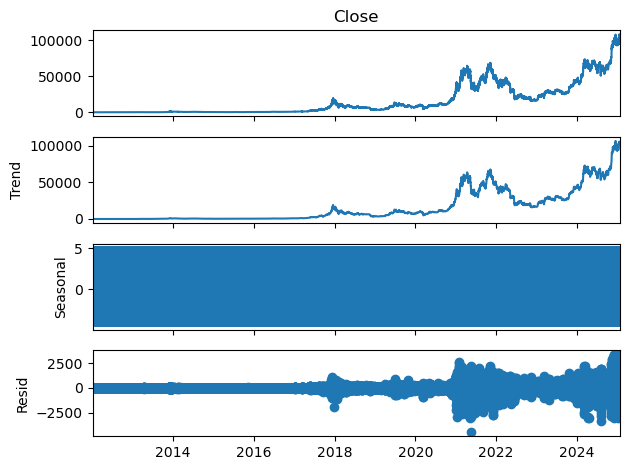

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Descomposición aditiva
resultado = seasonal_decompose(data_hour, model='additive')

# Representamos cada componente
resultado.plot()
plt.tight_layout()
plt.show()

In [11]:
print(data_hour)

Timestamp
2012-01-01 10:00:00         4.580000
2012-01-01 11:00:00         4.580000
2012-01-01 12:00:00         4.580000
2012-01-01 13:00:00         4.580000
2012-01-01 14:00:00         4.580000
                           ...      
2025-01-26 20:00:00    105046.750000
2025-01-26 21:00:00    104778.150000
2025-01-26 22:00:00    104516.550000
2025-01-26 23:00:00    103059.166667
2025-01-27 00:00:00    102514.000000
Freq: h, Name: Close, Length: 114591, dtype: float64


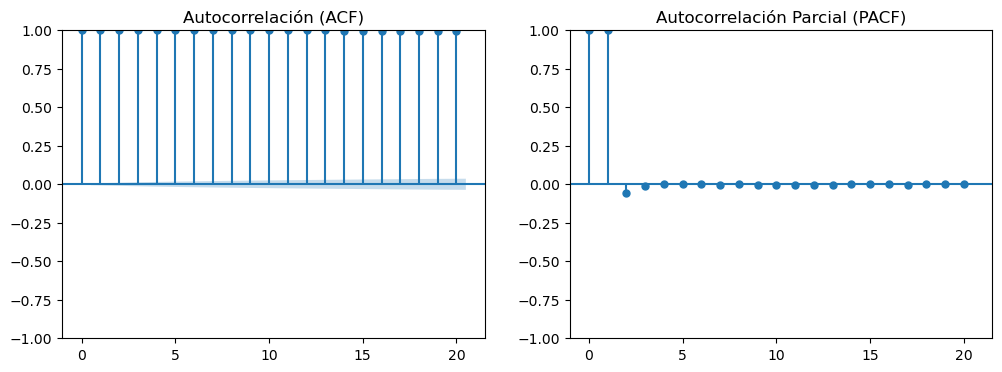

In [12]:

fig, ax = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(data_hour, lags=20, ax=ax[0])
ax[0].set_title("Autocorrelación (ACF)")

plot_pacf(data_hour, lags=20, ax=ax[1])
ax[1].set_title("Autocorrelación Parcial (PACF)")

plt.show()

In [13]:
# 1 año a considerar en el conjunto de test
n_steps = 24 * 364

# Dividimos la serie en train y test
train_size = len(data_hour) - n_steps
train, test = data_hour[:train_size], data_hour[train_size:]

# Ajustamos el modelo ARIMA
model = ARIMA(train, order=(2, 2, 1))
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=n_steps)
forecast_index = test.index

In [14]:
# 1 año a considerar en el conjunto de test
n_steps = 24 * 364

# Dividimos la serie en train y test
train_size = len(data_hour) - n_steps
train, test = data_hour[:train_size], data_hour[train_size:]

# Ajustamos el modelo ARIMA
model = ARIMA(train, order=(2, 1, 1)) #poner p d y q en caso de ejecutar auto_arima
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=n_steps)
forecast_index = test.index

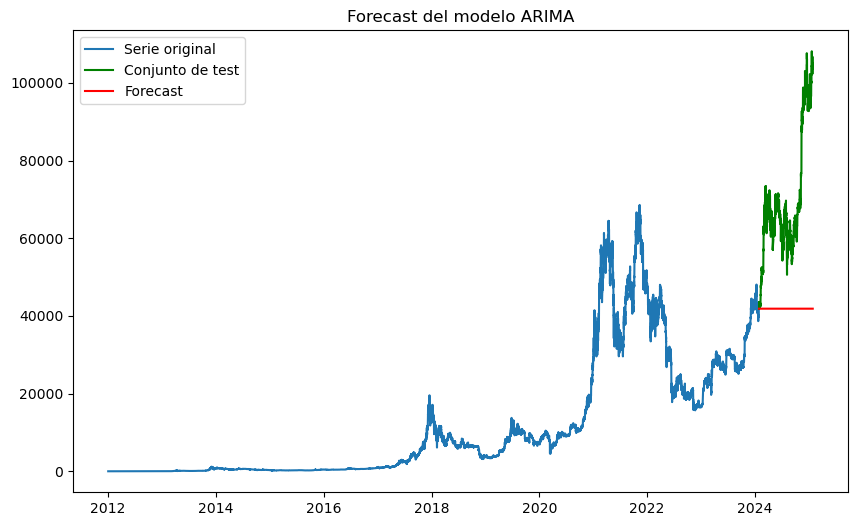

Mean Absolute Error: 28162.132669468436


In [15]:
# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Serie original')
plt.plot(test.index, test, label='Conjunto de test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast del modelo ARIMA')
plt.show()

# Evaluación del modelo
mae = mean_absolute_error(test, forecast)
print(f'Mean Absolute Error: {mae}')

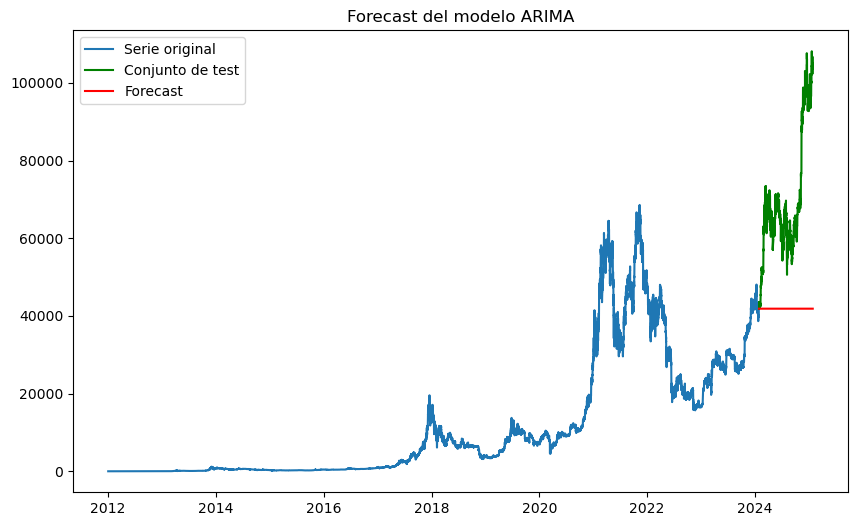

Mean Absolute Error: 28162.132669468436


In [16]:
# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Serie original')
plt.plot(test.index, test, label='Conjunto de test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast del modelo ARIMA')
plt.show()

# Evaluación del modelo
mae = mean_absolute_error(test, forecast)
print(f'Mean Absolute Error: {mae}')

In [17]:

from pmdarima import auto_arima
# Aplicar auto_arima para encontrar los mejores parámetros
modelo_auto = auto_arima(data_hour, 
                         seasonal=False,  
                         stepwise=True,   
                         trace=True,
                         error_action='ignore', 
                         suppress_warnings=True)

# Mostrar resumen del modelo seleccionado
print(modelo_auto.summary())

# Obtener los parámetros óptimos
p, d, q = modelo_auto.order

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1464362.777, Time=40.77 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1469342.436, Time=1.78 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1464612.145, Time=2.37 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1464361.579, Time=5.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1469344.664, Time=0.79 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1464361.994, Time=11.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1464361.993, Time=6.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1464361.507, Time=29.64 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1464364.147, Time=11.12 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1464363.936, Time=8.07 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1464363.862, Time=41.99 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1464365.810, Time=14.06 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1464362.176, Time=3.34 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total f

In [18]:
# Ajustamos el modelo ARIMA
model = ARIMA(train, order=(p, d, q)) #poner p d y q en caso de ejecutar auto_arima
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=n_steps)
forecast_index = test.index

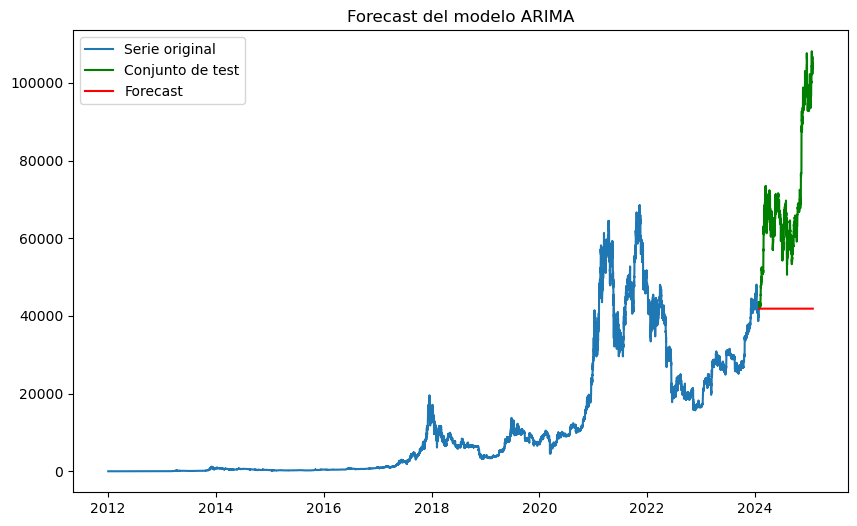

Mean Absolute Error: 28157.11822132116


In [19]:
# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Serie original')
plt.plot(test.index, test, label='Conjunto de test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast del modelo ARIMA')
plt.show()

# Evaluación del modelo
mae = mean_absolute_error(test, forecast)
print(f'Mean Absolute Error: {mae}')

In [25]:
# Probar con m=24 (patrón diario)
model_daily = auto_arima(data_hour,  
                         seasonal=False,  
                         stepwise=True,   
                         trace=True,
                         error_action='ignore',
                         m=24,
                         suppress_warnings=True)

p, d, q = model_daily.order
print(model_daily.summary())
# Ajustamos el modelo ARIMA
model = ARIMA(train, order=(p, d, q)) #poner p d y q en caso de ejecutar auto_arima
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=n_steps)
forecast_index = test.index

C:\Users\g3rm4\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (24) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1464362.777, Time=51.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1469342.436, Time=2.40 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1464612.145, Time=2.98 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1464361.579, Time=6.73 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1469344.664, Time=1.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1464361.994, Time=14.39 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1464361.993, Time=8.51 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1464361.507, Time=39.32 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1464364.147, Time=14.58 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1464363.936, Time=10.50 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1464363.862, Time=51.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1464365.810, Time=17.66 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1464362.176, Time=4.28 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total 

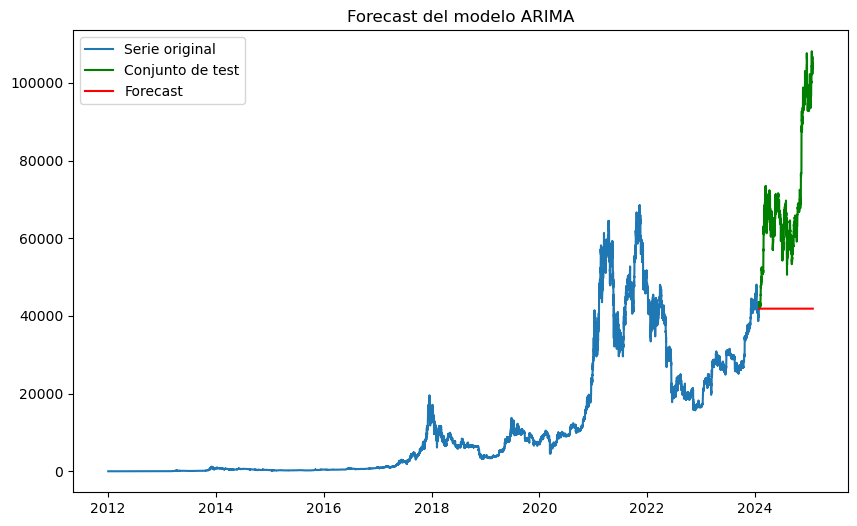

Mean Absolute Error: 28157.11822132116


In [27]:
# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Serie original')
plt.plot(test.index, test, label='Conjunto de test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast del modelo ARIMA')
plt.show()

# Evaluación del modelo
mae = mean_absolute_error(test, forecast)
print(f'Mean Absolute Error: {mae}')

In [29]:
# Probar con m=168 (patrón semanal)
model_weekly = auto_arima(data_hour,  
                         seasonal=False,  
                         stepwise=True,   
                         trace=True,
                         error_action='ignore',
                         m=168,
                         suppress_warnings=True)

p, d, q = model_weekly.order
print(model_weekly.summary())
# Ajustamos el modelo ARIMA
model = ARIMA(train, order=(p, d, q)) #poner p d y q en caso de ejecutar auto_arima
fitted_model = model.fit()

# Forecast
forecast = fitted_model.forecast(steps=n_steps)
forecast_index = test.index

C:\Users\g3rm4\anaconda3\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (168) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1464362.777, Time=45.51 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1469342.436, Time=2.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1464612.145, Time=3.00 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1464361.579, Time=6.97 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1469344.664, Time=1.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1464361.994, Time=14.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=1464361.993, Time=8.49 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1464361.507, Time=40.16 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=1464364.147, Time=14.94 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=1464363.936, Time=10.80 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1464363.862, Time=58.89 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=1464365.810, Time=17.85 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=1464362.176, Time=4.20 sec

Best model:  ARIMA(1,1,2)(0,0,0)[0] intercept
Total 

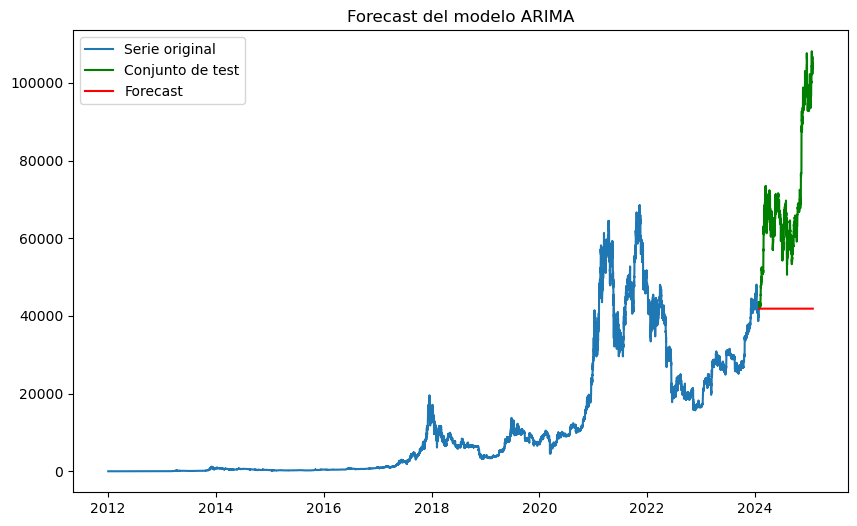

Mean Absolute Error: 28157.11822132116


In [30]:
# Visualizamos los resultados
plt.figure(figsize=(10, 6))
plt.plot(train, label='Serie original')
plt.plot(test.index, test, label='Conjunto de test', color='green')
plt.plot(forecast_index, forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecast del modelo ARIMA')
plt.show()

# Evaluación del modelo
mae = mean_absolute_error(test, forecast)
print(f'Mean Absolute Error: {mae}')